# Trabajo Práctico 2: RandomForest

Este modelo funciona similar a bagging, utilizar varios a modelos con diferentes sub-set del dataset de entrenamiendo. Pero con el agregado de que para evitar que mucho de estos modelos terminen pareciendoce mucho (debido a algunos features mas significativos que otros) se elije features de manera aleatoria.

Para este modelo se buscaran los siguientes hiperparametros:

+ criterion --> El criterio para medir el gain de generar una nueva particion de un nodo.
+ max_depth --> Maxima profundidad del arbol.
+ min_samples_split --> El número mínimo de muestras necesarias para dividir un nodo.
+ max_features --> La cantidad de características a considerar al buscar la mejor división.
+ class_weight --> Importancia de alto y bajo poder adquisitivo.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from preprocesamiento import feature_engineering
from preprocesamiento import obtenerDFTraining
from preprocesamiento import preprocesar_data_frame

RANDOM_STATE = 19 * 103785

In [12]:
# Imprime las metricas Recall, Precision, Accuracy, Roc-auc y muestra la matriz de confuncion.
def metricas(y_real, y_pred, x_test, modelo):

    data = {'y_real': y_real,
            'y_pred': y_pred}

    df_metricas = pd.DataFrame(data, columns=['y_real','y_pred'])
    confusion_matrix = pd.crosstab(df_metricas['y_real'], df_metricas['y_pred'], rownames=['Real'], colnames=['Predicho'])
    sns.heatmap(confusion_matrix, annot=True, fmt="d")
    plt.show()

    print("Recall: {}".format(recall_score(y_real, y_pred).round(2)))
    print("Precision: {}".format(precision_score(y_real, y_pred).round(2)))
    print("Acc: {}".format(accuracy_score(y_real, y_pred).round(2)))
    print("Roc: {}".format(roc_auc_score(y_real, modelo.predict_proba(x_test)[:, 1]).round(2)))

Inicialmente seleccionaremos las variables mas relevantes para las categoricas hacemos un one hot encoding y las numericas las escalaremos con MinMaxScaler.

In [3]:
def preprocesar_df_min_max_scaler(X : pd.DataFrame):
    scaler = MinMaxScaler()
    scaler.fit(X)
    return scaler.transform(X)

def prepros_RF(X):
    X_prepos = pd.get_dummies(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                       'estado_marital','genero',"edad","anios_estudiados"]],drop_first= True)

    X_prepos = preprocesar_df_min_max_scaler(X_prepos)

    return train_test_split(X_prepos, y, test_size=0.25, random_state=RANDOM_STATE)

In [8]:
parametros = {'n_estimators': [1000], 'criterion' : ['gini','entropy'], 'max_depth':range(5,11), 
              "min_samples_split" : [10,100,500,1000],"max_features": ["auto","log2"],
              'class_weight' :  [{0: 1,1: 1},{0: 1,1: 1.25},{0: 1,1: 1.5},{0: 1,1: 2}],
              'random_state':[RANDOM_STATE]} 

random_forest = RandomForestClassifier()
clf = GridSearchCV(random_forest, parametros, n_jobs = -1, verbose = 4, scoring = "roc_auc")

df = obtenerDFTraining()
(X, y) = preprocesar_data_frame(df)
x_train, x_test, y_train, y_test = prepros_RF(X)

clf.fit(x_train, y_train)
print(classification_report(y_test,clf.predict(x_test)))
clf.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 12.7min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 35.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 50.5min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 68.6min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 88.7min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 109.1min finished


              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6196
           1       0.77      0.55      0.64      1936

    accuracy                           0.85      8132
   macro avg       0.82      0.75      0.77      8132
weighted avg       0.85      0.85      0.84      8132



{'class_weight': {0: 1, 1: 1},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 10,
 'n_estimators': 1000,
 'random_state': 1971915}

Una vez realizada la busqueda, entrenamos individualmente el mejor modelo y vemos sus metricas.

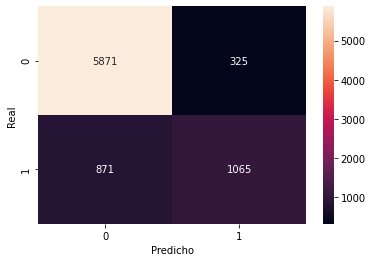

Recall: 0.55
Precision: 0.77
Acc: 0.85
Roc: 0.91


In [17]:
df = obtenerDFTraining()
(X, y) = preprocesar_data_frame(df)
x_train, x_test, y_train, y_test = prepros_RF(X)


clf_rf = RandomForestClassifier( class_weight = {0: 1, 1: 1}, criterion = 'gini', max_depth = 10,
                                max_features = 'auto',min_samples_split = 10,n_estimators = 1000,
                                random_state = RANDOM_STATE)

clf_rf.fit(x_train, y_train)

metricas(y_test,clf_rf.predict(x_test),x_test,clf_rf)

## Otro preprocesamiento: PCA

In [18]:
def preprocesar_df_min_max_scaler(X : pd.DataFrame):
    X = pd.get_dummies(X)
    
    X = X.drop(['trabajo_No contesto'],axis = 1)
    X = X.drop(['genero_mujer'],axis = 1)
    X = X.drop(['estado_marital_divorciado'],axis = 1)
    
    scaler = MinMaxScaler()
    scaler.fit(X)
    return scaler.transform(X)

def preprocesar_df_pca(df , dim):
    (X, Y) = preprocesar_data_frame(df)
    X = preprocesar_df_min_max_scaler(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados"]])
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=RANDOM_STATE)
    
    pca = PCA(dim)
    x_train_pca = pd.DataFrame(pca.fit_transform(x_train))
    x_test_pca = pca.transform(x_test)
    
    return (x_train_pca,x_test_pca,y_train,y_test)

In [20]:
parametros = {'n_estimators': [1000], 'criterion' : ['gini','entropy'], 'max_depth':range(5,11), 
              "min_samples_split" : [10,100,500,1000],"max_features": ["auto","log2"],
              'class_weight' :  [{0: 1,1: 1},{0: 1,1: 1.25},{0: 1,1: 1.5},{0: 1,1: 2}],
              'random_state':[RANDOM_STATE]} 

random_forest = RandomForestClassifier()
clf = GridSearchCV(random_forest, parametros, n_jobs = -1, verbose = 4,scoring = 'roc_auc')

df = obtenerDFTraining()
x_train, x_test, y_train, y_test  = preprocesar_df_pca(df,18)

clf.fit(x_train, y_train)
print(classification_report(y_test,clf.predict(x_test)))
clf.best_params_

Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 48.6min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 91.1min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 124.2min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 162.7min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 206.0min
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed: 255.5min finished


              precision    recall  f1-score   support

           0       0.87      0.92      0.89      6196
           1       0.69      0.55      0.61      1936

    accuracy                           0.83      8132
   macro avg       0.78      0.73      0.75      8132
weighted avg       0.83      0.83      0.83      8132



{'class_weight': {0: 1, 1: 1},
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_split': 10,
 'n_estimators': 1000,
 'random_state': 1971915}

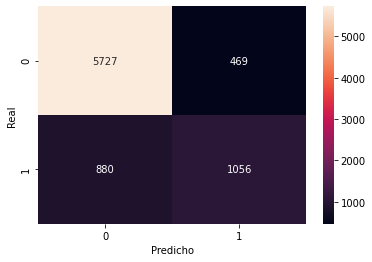

Recall: 0.55
Precision: 0.69
Acc: 0.83
Roc: 0.89


In [21]:
df = obtenerDFTraining()
x_train, x_test, y_train, y_test  = preprocesar_df_pca(df,18)


clf_rf = RandomForestClassifier( class_weight = {0: 1, 1: 1}, criterion = 'gini', max_depth = 10,
                                max_features = 'auto',min_samples_split = 10,n_estimators = 1000,
                                random_state = RANDOM_STATE)

clf_rf.fit(x_train, y_train)

metricas(y_test,clf_rf.predict(x_test),x_test,clf_rf)

Es interesante destacar que para ambos preprocesamiento, se encontro la misma configuraciones pero se puede notar una diferencia significativa en las metricas para ambos.